In [21]:
import tensorflow as tf
import numpy as np
import os
import random
import json
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVR
import joblib
import sys
sys.path.append("..") 

from models.resnet_model import build_ResNet

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.16.2


In [22]:
num_cpus = os.cpu_count()
num_gpus = len(tf.config.list_physical_devices('GPU'))

num_cpus, num_gpus

(14, 1)

In [18]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [19]:
def create_values(x_values_v, y_values_v):
  model = LinearRegression()
  x_values = np.array(x_values_v).reshape(-1, 1)
  model.fit(np.log(x_values), y_values_v)
  C1 = model.intercept_
  C2 = model.coef_[0]

  x_list = [round(0.1 * i, 1) for i in range(2, 11)] #To produce a list of values from 0.2 to 1.0
  values = C1 + C2 * np.log(x_list)

  return values


def get_values(file_path):
  with open(file_path, "r") as json_file:
    data = json.load(json_file)

  x_values = []
  y_values = []
  if 'horizontal' in file_path:
    for object_experiment in data:
      y_values.append(object_experiment["Accuracy_6"])
      x_values.append(object_experiment["data_volume"])
  elif 'vertical' in file_path:
    for object_experiment in data:
      y_values.append(object_experiment["Accuracy_6"])
      x_values.append((0.1*object_experiment["num_clients"]))

  y_val = create_values(x_values, y_values) #It retrieves list of values from the curve
  return y_val


def create_dataframe(file_path, meta_data, dataframe, base, extend):
  with open(file_path, "r") as json_file:
    data = json.load(json_file)

  if base:
    for object_exp in data:
      first_meta = meta_data[:]
      items_to_append = [object_exp['Accuracy_6'], object_exp['num_clients']]
      first_meta.extend(items_to_append)
      dataframe.loc[len(dataframe)] = first_meta

  if extend:
    values = get_values(file_path)
    volume = [i for i in range(1, 11)] # 2, 3, 4,...10
    for object_val, clients_volume in zip(values, volume):
      if clients_volume == 1:
        minimum_value = object_val
      if object_val > 1.0:
        object_val = 0.99
      first_meta = meta_data[:]
      if 'horizontal' in file_path:
        items_to_append = [minimum_value, object_val, round(0.1  * clients_volume, 1)]
      if 'vertical' in file_path:
        items_to_append = [minimum_value, object_val, clients_volume]
      first_meta.extend(items_to_append)
      dataframe.loc[len(dataframe)] = first_meta

  return dataframe

#Get some parameters of the dataset
def get_parameters(train_data_m, test_data_m):
  #Swap x_train and x_test because the test set is bigger
  X_test = np.expand_dims(train_data_m[:, 1:],axis=-1)
  y_test = train_data_m[:, 0]

  X_train = np.expand_dims(test_data_m[:, 1:], axis=-1)
  y_train = test_data_m[:, 0]

  y_train = tfk.utils.to_categorical(y_train)
  input_shape = X_train.shape[1:]
  classes = y_train.shape[-1]

  model_info = build_ResNet(input_shape, classes)

  return model_info.count_params(), X_train.shape[0], X_train.shape[1], classes

In [27]:
#Create a dataframe with named columns
columns = ['dataset_length', 'length_sequence', 'classes', 'num_param', 'mininum_value', 'accuracy', 'num_clients']
dataframe = pd.DataFrame(columns=columns)

files = ['../Datasets/Datasets_Training/ChlorineConcentration/results/Data Volume/vertical_results.json', '../Datasets/Datasets_Training/StarLightsCurves/results/Data Volume/results_vertical.json', '../Datasets/Datasets_Training/Yoga/results/Data Volume/vertical_results.json', '../Datasets/Datasets_Training/ItalyPowerDemand/results/Data Volume/vertical_results.json', '../Datasets/Datasets_Training/PhalangesOutlinesCorrect/results/Data Volume/vertical_results.json']
files_data = ['../Datasets/Datasets_Training/StarLightsCurves/StarLightCurves_TRAIN.txt', '../Datasets/Datasets_Training/StarLightsCurves/StarLightCurves_TEST.txt', '../Datasets/Datasets_Training/ChlorineConcentration/ChlorineConcentration_TRAIN.txt', '../Datasets/Datasets_Training/ChlorineConcentration/ChlorineConcentration_TEST.txt', '../Datasets/Datasets_Training/Yoga/Yoga_TRAIN.txt', '../Datasets/Datasets_Training/Yoga/Yoga_TEST.txt', '../Datasets/Datasets_Training/ItalyPowerDemand/ItalyPowerDemand_TRAIN.txt',  '../Datasets/Datasets_Training/ItalyPowerDemand/ItalyPowerDemand_TEST.txt', '../Datasets/Datasets_Training/PhalangesOutlinesCorrect/PhalangesOutlinesCorrect_TRAIN.txt', '../Datasets/Datasets_Training/PhalangesOutlinesCorrect/PhalangesOutlinesCorrect_TEST.txt']

#Retrieve values for parameter count of each dataset
for x_train_m, y_train_m in zip(files_data[::2], files_data[1::2]):
  train_data = np.loadtxt(x_train_m)
  test_data = np.loadtxt(y_train_m)

  params_model, dataset_length, sequances, classes = get_parameters(train_data, test_data)
  if 'ChlorineConcentration' in x_train_m:
    data_chlo = [dataset_length, sequances, classes, params_model]
  elif 'StarLightCurves' in x_train_m:
    data_star = [dataset_length, sequances, classes, params_model]
  elif 'Yoga' in x_train_m:
    data_yoga = [dataset_length, sequances, classes, params_model]
  elif 'Italy' in x_train_m:
    data_italy = [dataset_length, sequances, classes, params_model]
  elif 'Phalanges' in x_train_m:
    data_phal = [dataset_length, sequances, classes, params_model]

for file_path in files:
  if 'ChlorineConcentration' in file_path:
    dataframe = create_dataframe(file_path, data_chlo, dataframe, False, True)
  elif 'StarLightCurves' in file_path:
    dataframe = create_dataframe(file_path, data_star, dataframe, False, True)
  elif 'Yoga' in file_path:
    dataframe = create_dataframe(file_path, data_yoga, dataframe, False, True)
  elif 'Italy' in file_path:
    dataframe = create_dataframe(file_path, data_italy, dataframe, False, True)
  elif 'Phalanges' in file_path:
    dataframe = create_dataframe(file_path, data_phal, dataframe, False, True)

X_train_dataframe = dataframe.drop(columns=['num_clients'])
Y_train_dataframe = dataframe['num_clients']

print(X_train_dataframe)

X_training, X_testing, Y_training, Y_testing = train_test_split(X_train_dataframe, Y_train_dataframe, test_size=0.1, random_state=42)

encoder = LabelEncoder()
encoder.fit(Y_train_dataframe)
Y_train_dataframe = encoder.transform(Y_train_dataframe)

X_training, X_testing, Y_training, Y_testing = train_test_split(X_train_dataframe, Y_train_dataframe, test_size=0.1, random_state=42)


print(len(X_training))
print(len(X_testing))

models = {
    'LinearRegression': {
        'model': LinearRegression(),
        'param_grid': {}
    },
    'Ridge': {
        'model': Ridge(),
        'param_grid': {
            'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        }
    },
    'Lasso': {
        'model': Lasso(),
        'param_grid': {
            'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        }
    },
    'ElasticNet': {
        'model': ElasticNet(),
        'param_grid': {
            'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
        }
    },
    'SVR': {
        'model': SVR(),
        'param_grid': {}
    },
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'param_grid': {}
    },
    'DecisionTreeRegressor': {
        'model': DecisionTreeRegressor(),
        'param_grid': {}
    },
    'GradientBoostingRegressor': {
        'model': GradientBoostingRegressor(),
        'param_grid': {}
    }
  }

results = {}

for model_name, model_info in models.items():
  model = model_info['model']
  param_grid = model_info['param_grid']

  grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error')
  grid_search.fit(X_training, Y_training)

  best_model = grid_search.best_estimator_
  best_params = grid_search.best_params_

  y_pred = best_model.predict(X_testing)
  mse = mean_squared_error(Y_testing, y_pred)
  mse_values = (Y_testing - y_pred)
  print(mse_values)
  std = mse**0.5

  results[model_name] = {
      'model': best_model,
      'best_params': best_params,
      'mean_squared_error': mse,
      'std': std
  }

# Find and return the best model
best_model_name = min(results, key=lambda x: results[x]['mean_squared_error'])
best_model = results[best_model_name]['model']
best_param = results[best_model_name]['best_params']

names = []
mean = []
error = []
# Print the results
for model_name, model_result in results.items():
  print(f"Best {model_name} Model with Parameters: {model_result['best_params']}")
  names.append(model_name)
  print(f"Mean Squared Error: {model_result['mean_squared_error']}\n")
  mean.append(model_result['mean_squared_error'])
  print(f"Standard Deviation: {model_result['std']}\n")
  error.append(model_result['std'])

# Return the best model
print(f"The best model is: {best_model_name} alpha: {best_param}")
joblib.dump(best_model, 'models/reduction_model.joblib')  

    dataset_length  length_sequence  classes  num_param  mininum_value  \
0           3840.0            166.0      4.0   507076.0       0.839619   
1           3840.0            166.0      4.0   507076.0       0.839619   
2           3840.0            166.0      4.0   507076.0       0.839619   
3           3840.0            166.0      4.0   507076.0       0.839619   
4           3840.0            166.0      4.0   507076.0       0.839619   
5           3840.0            166.0      4.0   507076.0       0.839619   
6           3840.0            166.0      4.0   507076.0       0.839619   
7           3840.0            166.0      4.0   507076.0       0.839619   
8           3840.0            166.0      4.0   507076.0       0.839619   
9           3000.0            426.0      3.0   506947.0       0.739338   
10          3000.0            426.0      3.0   506947.0       0.739338   
11          3000.0            426.0      3.0   506947.0       0.739338   
12          3000.0            426.0   

['models/reduction_model.joblib']

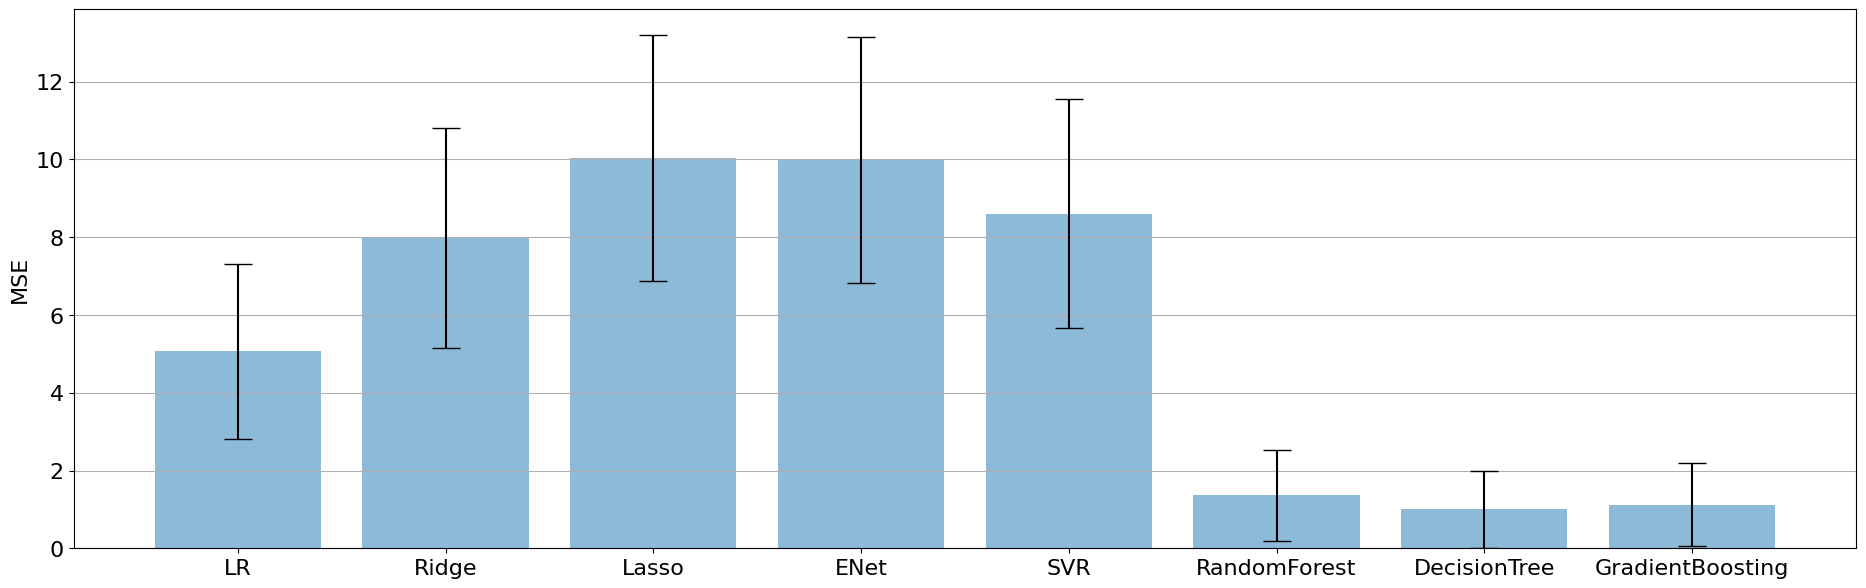

In [22]:
labels = ['LR', 'Ridge', 'Lasso', 'ENet', 'SVR', 'RandomForest', 'DecisionTree', 'GradientBoosting']
## Build the plot
fig, ax = plt.subplots(figsize=(23, 7))
ax.bar(names, mean,
       yerr=error,
       align='center',
       alpha=0.5,
       ecolor='black',
       capsize=10)
ax.set_ylabel('MSE')
ax.set_xticks(names)
ax.set_xticklabels(labels)
ax.yaxis.grid(True)

# Save the figure and show
#plt.tight_layout()
plt.savefig('bar_plot_with_error_bars.png')
plt.show()

In [20]:
model_input = np.array([[8.03400000e+03, 9.60000000e+01, 8.00000000e+00, 5.07592000e+05, 2.53663599e-01, 9.20000000e-01]])

reduction_model = joblib.load('../models/reduction_model.joblib')
reduction_model.predict(model_input)

/Users/mattia.sabella/Development/Green-Federated-Learning-a-Data-Centric-Approach-in-the-Cloud-Continuum/.venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but DecisionTreeRegressor was fitted with feature names
  warnings.warn(


array([4.])